# Transformers and Estimators

![](./images/transformers.jpg)

## Transformer   

- **For data preparation**

 -         **fit** find parameters from training data (if needed)
 -         **transform** apply to training or test data



- **StandardScaler** 

 -           **fit** find mean, standard deviation of each feature
 -            **transform** subtract mean, ten divide by sd

### Multiple Transformers

- Go through several transformation steps

*from sklearn.preprocessing import (Imputer, PolynomialFeatures,   StandardScaler)*

 imputer = Imputer()
 
 quadratic = PolynomialFeatures()
 
 standardizer = Standardscaler()

- No one wants to write this:

 X_train_imp = imputer.fit_transform(X_train_raw)
 
 X_train_quad = quadratic.fit_transform(X_train_imp)
 
 X_train = standardizer.fit_transform(X_train_quad)
 

- And then this:

 X_test_imp = imputer.transform(X_test_raw)
 
 X_test_quad = quadratic.transform(X_test_imp)
 
 X_test = standardizer.transform(X_test_quad) 

### Pipelines to the rescue !

- Instead, put steps together in a *Pipeline*

*from sklearn.pipeline import Pipeline*

pipeline = Pipeline([
        ('imputer', Imputer() ),
        ('quadratic', PolynomialFeatures()),
        ('standardizer', StandardScaler() )
        ])  

X_train = pipeline.fit_transform(X_train_raw)

X_test = pipeline.transform(X_test_raw)


### Transformers in Parallel

- Try more than one transformation
- Put steps together with a *FeatureUnion*

*from sklearn.pipeline import FeatureUnion*

feature_union = FeatureUnion([
            ('fill_avg', Imputer(strategy='mean')),
            ('fill_mid', Imputer(strategy='median')),
            ('fill_freq', Imputer(strategy='most_frequent'))]
            
X_train = feature_union.fit_transform(X_train_raw)

X_test = feature_union.transform(X_test_raw)
        

In [1]:
import pandas as pd
import numpy as np
import os

path_to_data = os.path.join('.','data','Special_Events_Permits_2016.csv')

df = pd.read_csv(path_to_data, usecols=['permit_type',
 'event_category',
 'event_sub_category',
 'event_location_park',
 'event_location_neighborhood',
 'attendance', 'permit_status'])
df.head()

,permit_status,permit_type,event_category,event_sub_category,event_location_park,event_location_neighborhood,attendance
0,Complete,Special Event,Athletic,Run/Walk,Gas Works Park,Multiple Neighborhoods,4500.0
1,Complete,Special Event,Commercial,NaN,NaN,Capitol Hill,27000.0
2,Complete,Special Event,Community,NaN,NaN,Pioneer Square,705.0
3,Complete,Special Event,Community,NaN,NaN,Pioneer Square,705.0
4,Complete,Special Event,Community,NaN,NaN,Pioneer Square,705.0


In [2]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df)

In [3]:
df_train['permit_status'].unique()

array(['Complete', 'In Process', 'Cancelled'], dtype=object)

In [16]:
df.permit_type.unique()

array(['Special Event', 'Valet Parking', 'Charter Vessel'], dtype=object)

*EDA - event_location_park*

In [6]:
# Event park: mostly N/A, not exhaustive list
(df_train.event_location_park.value_counts(dropna=False)).head()

NaN                359
Magnuson Park        9
Gas Works Park       7
Occidental Park      4
Volunteer Park       2
Name: event_location_park, dtype: int64

In [7]:
# Estimated Attendance: few missing, right skewed

df_train.attendance.isnull().sum()

3

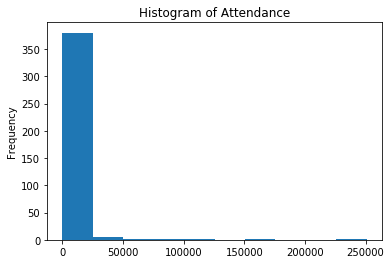

In [9]:
import matplotlib.pyplot as plt

x = df_train.attendance
x.plot(kind='hist', title = 'Histogram of Attendance')



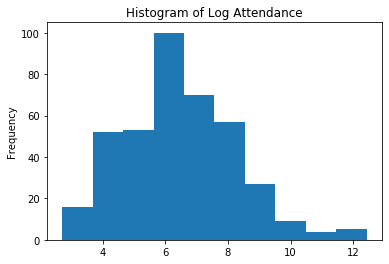

In [11]:
np.log(x).plot(kind='hist', title = 'Histogram of Log Attendance')

Help! My Transformer Doesn't Exist!

- Use a **FunctionTransformer**
 - Turns any function into a transformer
 - Works well for stateless transformations

In [ ]:
from sklearn.preprocessing import FunctionTransformer

logger = FunctionTransformer(np.log1p)

W_log = logger.transform(X)

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline 

In [5]:
#- Or write your own cunstomer Transformer


class Log1pTransformer(TransformerMixin):

        def fit(self, X, y=None):
            return self
            
        def transform(self, X):
            Xlog = np.log1p(X)
            return Xlog

In [6]:
class ZeroFillTransformer(TransformerMixin):

        def fit(self, X, y=None):
            return self
            
        def transform(self, X):
            zfill = X.fillna(value=0)
            return zfill

### Custom Transformer- One Hot Encoding

- Goal: Turn string column into set of dummy variables


In [7]:
from sklearn.feature_extraction import DictVectorizer

class DummyTransformer(TransformerMixin):
    
    def __init__(self):
        self.dv = None
        
    def fit(self, X, y=None):
        Xdict = X.to_dict('records')
        self.dv = DictVectorizer(sparse= False)
        self.dv.fit(Xdict)
        return self

    def transform(self, X):
    
        Xdict = X.to_dict('records')
        Xt = self.dv.transform(Xdict)
        cols = self.dv.get_feature_names()
        Xdum = pd.DataFrame(Xt, index= X.index, columns = cols)
        return Xdum
        

- Convert each row to map: column name --> value
- then fit DictVectorizer


- Convert to map and apply *DictVectrorizer*
- then convert back to DataFrame


### Custom Transformer - Subset Columns

In [8]:
class ColumnExtractor(TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xcols = X[self.cols]
        return Xcols

In [9]:
#Custom Transformer that extracts columns passed as argument to its constructor 

class FeatureSelector( BaseEstimator, TransformerMixin ):

    #Class Constructor 

    def __init__( self, feature_names ):

        self._feature_names = feature_names 

    

    #Return self nothing else to do here    

    def fit( self, X, y = None ):

        return self 

    

    #Method that describes what we need this transformer to do

    def transform( self, X, y = None ):

        return X[ self._feature_names ] 

### Customer Transformer - Standardization


In [82]:
from sklearn.preprocessing import (Imputer, PolynomialFeatures,   StandardScaler)

class DFStandardScaler(TransformerMixin):
    
    def __init__(self):
        self.ss = None
        
    def fit(self, X, y=None):
        self.ss = StandardScaler().fit(X)
        return self
    
    def transform(self, X):
        Xss = self.ss.transform(X)
        Xscaled = pd.DataFrame(Xss)
        return Xscaled

### Putting it All Together -Feature Engineering 

- List feature by transformation strategy


In [57]:
df.shape

(529, 7)

In [61]:
(df.isna().sum()/df.shape[0])*100

permit_status                   0.000000
permit_type                     0.000000
event_category                 19.092628
event_sub_category             85.066163
event_location_park            92.060491
event_location_neighborhood     0.000000
attendance                      0.567108
dtype: float64

In [86]:
CAT_FEATS = ['permit_type','event_category',
       'event_location_neighborhood' ]

NUM_FEATS = ['attendance']

In [93]:
# One Hot Encoding for categorical features
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
pipeline = Pipeline([ 
('features', FeatureUnion([
    
('categoricals',Pipeline([('extract', FeatureSelector(CAT_FEATS)),
                           #('fill_freq', Imputer(strategy='most_frequent')),
                          ('dummy', DummyTransformer())
                         ])),
 ('numerics', Pipeline([('extract', FeatureSelector(NUM_FEATS)),
                          ('zero_fill', ZeroFillTransformer()),
                         ('log', Log1pTransformer())
                         ]))])),
    ('scale', DFStandardScaler())])

### Putting it All Together- A Better Model

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [95]:



# Apply Pipeline

X_train = pipeline.fit_transform(df_train.drop(['permit_status'], axis=1))

X_test = pipeline.transform(df_test.drop(['permit_status'], axis=1))

y_train = np.where(df_train.permit_status == 'Complete', 1, 0)

y_test = np.where(df_test.permit_status == 'Complete', 1, 0)

# Fit model
model = LogisticRegression()
model.fit(X_train.drop(labels=0, axis=1), y_train)

# Predict on test data

p_pred_test = model.predict_proba(X_test.drop(labels=0, axis=1))[:, 1]

# Measure performance on test data

auc_test = roc_auc_score(y_test, p_pred_test)

C:\Users\ASSAHOUA JOSEPH\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [96]:
auc_test

0.639423076923077

## Estimator

- **For modeling**

 - **fit** find parameters from training data
 - **predict** apply to training or test data

- **LogisticRegression**

  -  **fit** find coefficients in logistic regression formula
  -  **predict** plug into formula, get predicted class